In [7]:
import qiskit
from qiskit import QuantumCircuit, assemble, transpile, Aer,BasicAer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import pandas as pd
from qiskit.circuit.library import ZGate
#import matplotlib as mpl
import math 
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy


IBMQ.save_account('0c5f09afe94bb9159f65f3ae983bdad4fd4fe1ef0fe97a1f9167ffc44c733c5ccb21d848987d3c1796fc3a40e2143fc5f902ddb2526a3df548c3b0ea53cba38f')
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2021-09-23 18:26:26,670: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-09-23 18:26:27,580: Credentials are already in use. The existing account in the session will be replaced.


$ Q = A S_0 A^{\dagger} S_f $

$A$ $->$ initial search state for the algorithm, i.e. just equal superposition

$S_0$ $->$ Reflection about 0

$S_f$ $->$ Oracle that applies function f(x)

In [8]:
def superpos(qc, n):
    for i in range(n):
        qc.h(i)
    return qc

In [9]:
# Example phase-flip oracle
def oracle(n):
    qc = QuantumCircuit(n)
    qc.cz(0,n-1)
    qc.cz(1,n-1)
    O = qc.to_gate()
    O.name = "O_f"
    return O

### Reflection

$ U_S = -H^ {\otimes n} X^{\otimes n}(MCZ)X^{\otimes n} H^{\otimes n} $

In [10]:
def R(n):
    qc = QuantumCircuit(n)
    
    superpos(qc, n)

    for i in range(n):
        qc.x(i)

    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)

    for i in range(n):
        qc.x(i)
        
    for i in range(n):
        qc.h(i)
    Us = qc.to_gate()
    Us.name = "R"
    return Us

if M in no. of solutions, already known, N is total number of strings in dataset
amp of good state (solution) is $cos^{-1}(\sqrt{\frac{M}{N}})$

In [25]:
def num_iterations(num_solutions, n):
    
    #return math.ceil(np.pi*sqrt(2**n)/4)
    
    amplitude = np.sqrt(num_solutions / 2 ** n)
    return round(np.arccos(amplitude) / (2 * np.arcsin(amplitude)))

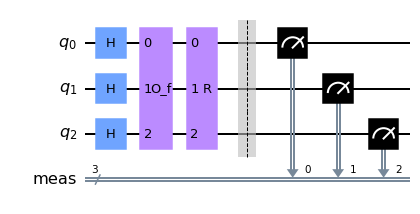

In [26]:
n = 3
num_solutions= 2 #According to the oracle, which are the marked States
m = num_iterations(num_solutions, n)
grover_aa = QuantumCircuit(n)
grover_aa = superpos(grover_aa, n)

for ix in range(1):
    grover_aa.append(oracle(n), list(range(n)))
    grover_aa.append(R(n), list(range(n)))

grover_aa.measure_all()
grover_aa.draw('mpl')

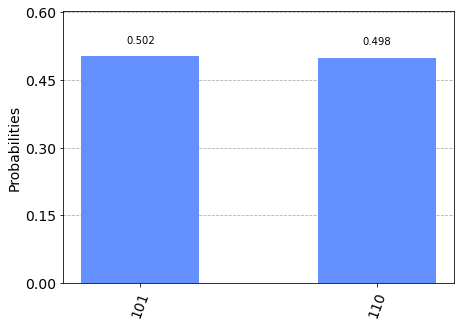

In [27]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(grover_aa, aer_sim)
qobj = assemble(transpiled_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [153]:
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", device)

least busy backend:  ibmq_bogota


In [155]:
transpiled_gcircuit = transpile(grover_aa, device, optimization_level=3)
job = device.run(transpiled_gcircuit)
job_monitor(job, interval=2)

Job Status: job incurred error


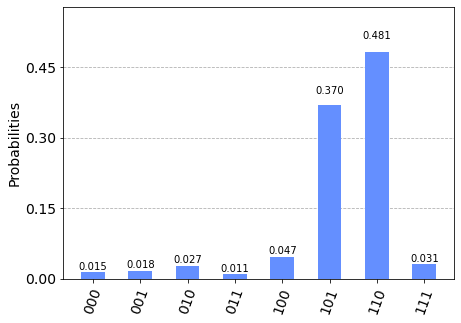

In [135]:
results = job.result()
answer = results.get_counts(grover_aa)
plot_histogram(answer)